In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from prettytable import PrettyTable
from scipy.stats import randint as sp_randint

from sklearn import set_config, tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.metrics import mean_squared_error

In [2]:
set_config(display='diagram', transform_output='pandas')

In [3]:
np.random.seed(seed=100505652)

In [4]:
wind_ava = pd.read_csv('wind_available.csv.gzip', compression="gzip")

In [5]:
wind_ava.describe()

,energy,year,month,day,hour,p54.162.1,p54.162.2,p54.162.3,p54.162.4,p54.162.5,...,v100.16,v100.17,v100.18,v100.19,v100.20,v100.21,v100.22,v100.23,v100.24,v100.25
count,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000,4.376000e+03,4.287000e+03,4.485000e+03,4.434000e+03,4.259000e+03,...,4140.000000,4181.000000,4018.000000,3816.000000,4480.000000,4487.000000,4361.000000,4179.000000,4169.000000,4312.000000
mean,693.126247,2006.628475,6.628054,15.652485,9.123842,2.512664e+06,2.504671e+06,2.497395e+06,2.489648e+06,2.481708e+06,...,0.230065,0.277537,0.359449,0.438263,0.406071,0.225057,0.260836,0.280071,0.332205,0.404362
std,665.531609,1.414856,3.475914,8.844734,6.755085,4.498680e+04,4.519397e+04,4.504295e+04,4.483586e+04,4.460474e+04,...,4.902399,4.813315,4.666727,4.493713,4.342197,4.869798,4.725219,4.569511,4.442757,4.314635
min,0.010000,2005.000000,1.000000,1.000000,0.000000,2.380562e+06,2.373125e+06,2.365683e+06,2.358246e+06,2.350809e+06,...,-13.737945,-13.359267,-12.980589,-12.601412,-12.222734,-13.712999,-13.326339,-11.274292,-12.552518,-12.165857
25%,144.170000,2005.000000,4.000000,8.000000,6.000000,2.481905e+06,2.473722e+06,2.466373e+06,2.458621e+06,2.451135e+06,...,-3.572133,-3.464741,-3.239355,-3.020580,-2.933020,-3.528852,-3.393895,-3.224513,-3.068601,-2.864918
50%,465.305000,2006.000000,7.000000,16.000000,12.000000,2.513508e+06,2.505370e+06,2.498471e+06,2.490711e+06,2.482535e+06,...,-0.515392,-0.450284,-0.387420,-0.180619,-0.237745,-0.507160,-0.464253,-0.385424,-0.329047,-0.261194
75%,1089.375000,2007.000000,10.000000,23.000000,18.000000,2.548502e+06,2.540545e+06,2.533515e+06,2.525281e+06,2.517041e+06,...,3.732389,3.668777,3.663663,3.606537,3.467963,3.697215,3.612399,3.489915,3.454242,3.400235
max,2792.550000,2009.000000,12.000000,31.000000,18.000000,2.604194e+06,2.596310e+06,2.588421e+06,2.580532e+06,2.572648e+06,...,17.730758,17.229346,16.774832,16.366718,15.959103,17.571603,17.080170,16.588237,16.096804,15.681705


In [6]:
wind_ava.head()

,energy,year,month,day,hour,p54.162.1,p54.162.2,p54.162.3,p54.162.4,p54.162.5,...,v100.16,v100.17,v100.18,v100.19,v100.20,v100.21,v100.22,v100.23,v100.24,v100.25
0,402.71,2005,1,2,18,2.534970e+06,2.526864e+06,2.518754e+06,2.510648e+06,2.502537e+06,...,-4.683596,NaN,-4.407196,NaN,-4.131295,-4.669626,-4.528932,-4.388736,-4.248540,-4.107846
1,696.80,2005,1,3,0,NaN,NaN,2.521184e+06,2.513088e+06,NaN,...,-3.397886,-3.257192,-3.115998,-2.975304,-2.834609,-3.396390,-3.254198,-3.112506,-2.970314,NaN
2,1591.15,2005,1,3,6,2.533727e+06,2.525703e+06,2.517678e+06,2.509654e+06,NaN,...,-1.454105,NaN,-1.138290,NaN,-0.822476,-1.459094,-1.302933,-1.147271,-0.991110,-0.834949
3,1338.62,2005,1,3,12,NaN,2.526548e+06,2.518609e+06,2.510670e+06,2.502732e+06,...,1.255015,1.370265,1.485515,1.600765,1.716015,1.210612,1.319376,1.428140,1.536405,1.645169
4,562.50,2005,1,3,18,2.529543e+06,NaN,2.513702e+06,2.505782e+06,2.497861e+06,...,1.939031,NaN,NaN,2.193977,2.278793,1.873673,1.953000,2.031829,2.111157,2.189986


## EXERCISE 2: EDA (0.4 points)

We have 4748 instances (number of rows) and 555 variables (number of columns).

In [7]:
wind_ava.shape

(4748, 555)

### TYPES OF VARIABLES

In [8]:
variable_types = wind_ava.dtypes
print(variable_types)

energy     float64
year         int64
month        int64
day          int64
hour         int64
            ...   
v100.21    float64
v100.22    float64
v100.23    float64
v100.24    float64
v100.25    float64
Length: 555, dtype: object


In [9]:
unique_variable_types = wind_ava.dtypes.unique()
print(unique_variable_types)

[dtype('float64') dtype('int64')]


We can see that all variables are numeric; however, year, month, day and hour could be considered as multicategorical. 

### MISSING VALUES

In [10]:
# To count NaN values in the entire DataFrame
nan_count = wind_ava.isna().sum().sum()
print(f"Total NaN count: {nan_count}")

Total NaN count: 326132


We have a total of 326132 missing values. We want to see how many are there in each of the variables.

In [11]:
# Count NaN values only for columns that have at least one NaN value
nan_counts_per_variable = wind_ava.loc[:, wind_ava.isna().any()].isna().sum()

# Display the result
print("Number of NaN values in each variable with at least one NaN value:")
print(nan_counts_per_variable)

Number of NaN values in each variable with at least one NaN value:
p54.162.1    372
p54.162.2    461
p54.162.3    263
p54.162.4    314
p54.162.5    489
            ... 
v100.21      261
v100.22      387
v100.23      569
v100.24      579
v100.25      436
Length: 550, dtype: int64


In [12]:
# Calculate the percentage of NaN values only for columns that have at least one NaN value
nan_percentage_per_variable = (wind_ava.loc[:, wind_ava.isna().any()].isna().mean() * 100).round(2)

# Display the result
print("Percentage of NaN values in each variable with at least one NaN value:")
print(nan_percentage_per_variable)

Percentage of NaN values in each variable with at least one NaN value:
p54.162.1     7.83
p54.162.2     9.71
p54.162.3     5.54
p54.162.4     6.61
p54.162.5    10.30
             ...  
v100.21       5.50
v100.22       8.15
v100.23      11.98
v100.24      12.19
v100.25       9.18
Length: 550, dtype: float64


### CONSTANT VARIABLES?

In [13]:
# Check for constant variables
constant_variables = wind_ava.columns[wind_ava.nunique() == 1]

# Display the constant variables, if any
if len(constant_variables) > 0:
    print("Constant variables found:")
    print(constant_variables)
else:
    print("No constant variables found.")

No constant variables found.


There are no constant variables

# REGRESSION OR CLASSIFICATION PROBLEM

Energy is the response variables and it is a regression problem because we predict a continuous variable (the amount of energy produced in Sotavento).

### OTHER INTERESTING THINGS

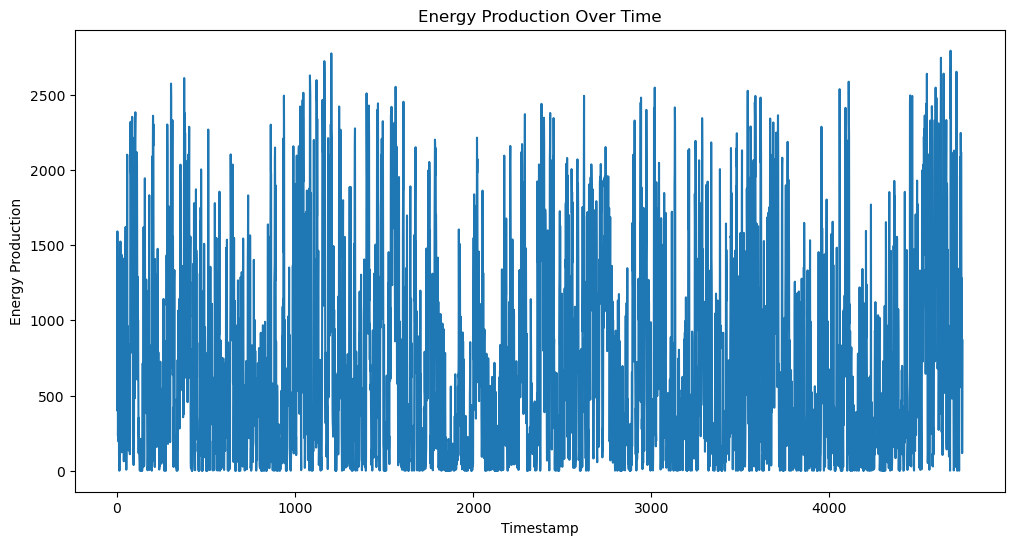

In [14]:
#Time trends
plt.figure(figsize=(12, 6))
plt.plot(wind_ava.index, wind_ava['energy'])

plt.title('Energy Production Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Energy Production')
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

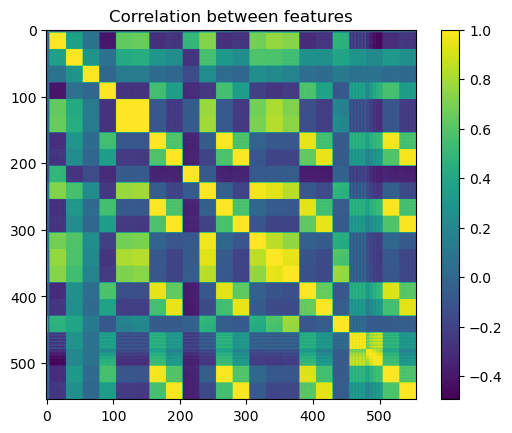

In [15]:
corr = wind_ava.corr()
im = plt.imshow(corr.to_numpy())
plt.colorbar(im)
plt.title('Correlation between features')
plt.show()

## EXERCISE 3: split the data and decide the metric (0.2 points)

We want to see how many observations there are in each year to know how to split the data.

In [16]:
wind_ava['year'].value_counts()

2006    1272
2005    1256
2007    1121
2009     921
2008     178
Name: year, dtype: int64

We decide to take whole years, so we take as the training data 2005-2007 and as the test data 2008-2009. We separate all the variables from the response variable also.

In [17]:
X_train = wind_ava.loc[:3649].drop('energy', axis=1, inplace=False)
y_train = wind_ava.loc[:3649,"energy"]

X_test = wind_ava.loc[3649:,:].drop(labels='energy', axis=1, inplace=False)
y_test = wind_ava.loc[3649:,"energy"]

To evaluate the goodness of our Machine Learning models we will use a common metric: mean squared error (MSE). This metric is widely known to have a faster rate of convergence than mean absolute error (MAE), although it is more influenced by outliers in the dataset.

## EXERCISE 4: using default hyper-parameters, evaluate Trees and KNN on the testing partition. For KNN, you should a pipeline with preprocessing included (scaling, at least). You can compare 2 scaling methods for KNN. (0.5 points)

To start the modelling, we will compare some Machine Learning methods in the simplest way: using their default hyperparameters. More specifically, Decision Tree (DT), K-Nearest Neighbors (KNN), Support Vector Machine (SVM) and Random Forest (RF) will be compared. Furthermore, for those methods that require scaling (KNN and SVM) two differents methods of scaling will be compared.

It is worth mentioning that as we have seen the dataset contains a lot of instances with NA values in some variable. Although some of these methods are prepared to deal with this, all of the NAs will be imputed using an imputation method based on K-Nearest Neighbors.

### Decision Tree

We begin by fitting and testing a Decision Tree model, whose default hyperparameters include a minimum number of samples required to split of 2 and no maximim depth of the tree.

In [18]:
tree_pipe = Pipeline([
    ('imputation', KNNImputer()),
    ('tree_regression', tree.DecisionTreeRegressor(random_state=0))
])

start = time.time()
tree_pipe.fit(X_train,y_train)
print(f" Training the Decision Tree using default hyperparameters took: {time.time() - start:.2f}s")

y_tree_pred = tree_pipe.predict(X_test)

 Training the Decision Tree using default hyperparameters took: 18.01s


In [19]:
print(f"MSE for Decision Tree: {mean_squared_error(y_test,y_tree_pred):.2f}")

MSE for Decision Tree: 288678.19


### K-Nearest Neighbors

We continue with K-Nearest Neighbors. Among the default hyperparameters for this method we find the use of the 5 nearest neighbors for regression.

As mentioned earlier, we will compare two methods of scaling: MinMax and standardization.

In [20]:
knn_pipe_standard = Pipeline([
    ('imputation', KNNImputer()),
    ('standardization', StandardScaler()),
    ('knn_regression', KNeighborsRegressor())
])

start = time.time()
knn_pipe_standard.fit(X_train, y_train)
print(f"Training the KNN using default hyperparameters with standardization scaling took: {time.time()-start:.2f}s")
y_knn_pred_standard = knn_pipe_standard.predict(X_test)

Training the KNN using default hyperparameters with standardization scaling took: 15.42s


In [21]:
knn_pipe_minmax = Pipeline([
    ('imputation', KNNImputer()),
    ('standardization', MinMaxScaler()),
    ('knn_regression', KNeighborsRegressor())
])

start = time.time()
knn_pipe_minmax.fit(X_train, y_train)
print(f"Training the kNN using default hyperparameters with MinMax scaling took: {time.time()-start:.2f}s")
y_knn_pred_minmax = knn_pipe_minmax.predict(X_test)

Training the kNN using default hyperparameters with MinMax scaling took: 15.50s


In [22]:
print(f"MSE for kNN with StandardScaler: {mean_squared_error(y_test, y_knn_pred_standard):.2f}")
print(f"MSE for kNN with MinMaxScaler: {mean_squared_error(y_test, y_knn_pred_minmax):.2f}")

MSE for kNN with StandardScaler: 188578.44
MSE for kNN with MinMaxScaler: 213309.80


As we can observe from the reported MSE, we can safely say that scaling the data through standardisation seems to lead to more accurate results.

### Support Vector Machine

Moving on to Support Vector Machine, we observe that the default hyperparameter for this Machine Learning method is a polynomial kernel function of degree 3. It is also worth mentioning that since this methods relies on the use of the Euclidean distance, the input data should be scaled.

Just like in the case of KNN, MinMax scaling and standardisation will be compared.

In [23]:
svm_pipe_standard = Pipeline([
    ('imputation', KNNImputer()),
    ('standardization', StandardScaler()),
    ('svm_regression', SVR())
])

start = time.time()
svm_pipe_standard.fit(X_train, y_train)
print(f"Training the SVM using default hyperparameters with standardization scaling took: {time.time()-start:.2f}s")
y_svm_pred_standard = svm_pipe_standard.predict(X_test)

Training the SVM using default hyperparameters with standardization scaling took: 18.41s


In [24]:
svm_pipe_minmax = Pipeline([
    ('imputation', KNNImputer()),
    ('standardization', MinMaxScaler()),
    ('svm_regression', SVR())
])

start = time.time()
svm_pipe_minmax.fit(X_train, y_train)
print(f"Training the SVM using default hyperparameters with MinMax scaling took: {time.time()-start:.2f}s")
y_svm_pred_minmax = svm_pipe_minmax.predict(X_test)

Training the SVM using default hyperparameters with MinMax scaling took: 17.87s


In [25]:
print(f"MSE for SVM with StandardScaler: {mean_squared_error(y_test, y_svm_pred_standard):.2f}")
print(f"MSE for SVM with MinMaxScaler: {mean_squared_error(y_test, y_svm_pred_minmax):.2f}")

MSE for SVM with StandardScaler: 436081.01
MSE for SVM with MinMaxScaler: 465214.35


Once again, we find that scaling through standardisation gives better predictions.

### Random Forest

Finally, we will use the Machine Learning algorithm known as Random Forest. Some hyperparameters of this method are the number of trees in the forest, set by default to 100, or the maximum depth of threes, which is uncapped by default. 

In [26]:
rf_pipe = Pipeline([
    ('imputation', KNNImputer()),
    ('rf_regression', RandomForestRegressor(random_state=0))
])

start = time.time()
rf_pipe.fit(X_train,y_train)
print(f"Training the RF using default hyperparameters took: {time.time() - start:.2f}s")

y_rf_pred = rf_pipe.predict(X_test)

Training the RF using default hyperparameters took: 175.02s


In [27]:
print(f"MSE for Decision Tree: {mean_squared_error(y_test,y_rf_pred):.2f}")

MSE for Decision Tree: 150294.01


All in all, we have seen that using default hyperparameters, the best method in terms of the mean squared error of its predictions seems to be Random Forest, while the worst would be Support Vector Machines. In terms of this same metric, the best scaling method for both K-Nearest Neighbors and Support Vector Machine seems to be standardisation.

As far as training time is concerned, Random Forest is almost 10 times slower than Support Vector Machine, with the training times of Decision Tree and K-Nearest Neighbors being less than or around two times slower.

Next, we will study whether this results might change as well as how much each method might improve through hyperparameter tuning.

## EXERCISE 5: do hyper-parameter tuning (HPO) for trees and KNN. Report a summary (table) of the results so far and draw conclusions about accuracy, comparing the evaluation of all alternatives tested (0.8 points)

For the tuning of the different hyperparameters, 5-fold cross validation will be used. This is a process that can be very computationally costly if using a grid search method. In order to avoid excessive computation times, a randomized search method will be used instead, although with the trade-off of possibly missing the most optimal hyperparameter combination. The randomised search will check 10 combination of hyperparameters and perform cross validation on a model fitted with them. 

It is worth mentioning that this process has been further accelerated with the use of parallelisation (the argument n_jobs within RandomizedSearchCV). Were this program to be run on a computer with a less potent CPU, this argument should be omitted.

### K-Nearest Neighbours

To start, hyperparameter tuning will be carried for K-Nearest Neighbors. The only parameter that we will look to optimize is the number of nearest neighbors used for regression, n_neighbors.

In [28]:
knn = KNeighborsRegressor()
scaler = StandardScaler()
imputer = KNNImputer()

knn_pipe = Pipeline([
    ('imputation', imputer),
    ('standardization', scaler),
    ('knn_regression', knn)
])

inner_cv = KFold(n_splits=5, shuffle=False)

knn_grid = {
    'knn_regression__n_neighbors': sp_randint(2,40)
}

In [29]:
knn_search = RandomizedSearchCV(knn_pipe, 
                                knn_grid, 
                                scoring='neg_mean_squared_error', 
                                cv=inner_cv, verbose=2, n_jobs=4, random_state=0)

start = time.time()
knn_search = knn_search.fit(X_train, y_train)
print(f"Training the KNN regressor with HPO took: {time.time()-start:.2f}s")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training the KNN regressor with HPO took: 257.97s


In [30]:
y_pred_knn = knn_search.predict(X_test)

In [31]:
print("Best Hyperparameters for KNN:", knn_search.best_params_)
print(f"MSE for KNN on Test Set: {mean_squared_error(y_test, y_pred_knn):.2f}")

Best Hyperparameters for KNN: {'knn_regression__n_neighbors': 21}
MSE for KNN on Test Set: 181416.42


### Decision Tree

The two hyperparameters tuned for Decision Tree are the minimum number of samples required to split a node, min_samples_split, and the maximim depth of tree, max_depth.

In [32]:
tree_pipe = Pipeline([
    ('imputation', KNNImputer()),
    ('tree_regression', tree.DecisionTreeRegressor())
])

inner_cv = KFold(n_splits=5, shuffle=False)

In [33]:
tree_grid = {
    'tree_regression__min_samples_split': sp_randint(2,200),
    'tree_regression__max_depth': sp_randint(2, 20)
}

tree_search = RandomizedSearchCV(tree_pipe, 
                                 tree_grid, 
                                 scoring='neg_mean_squared_error', 
                                 cv=inner_cv, verbose=2, n_jobs=4, random_state=0)

start = time.time()
tree_search = tree_search.fit(X_train, y_train)
print(f"Training the Decision Tree with HPO took: {time.time()-start:.2f}s")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training the Decision Tree with HPO took: 262.81s


In [34]:
y_pred_tree = tree_search.predict(X_test)

In [35]:
print("Best Hyperparameters for Decision Tree:", tree_search.best_params_)
print("")
print(f"MSE for Decision Tree on Test Set: {mean_squared_error(y_test, y_pred_tree):.2f}")

Best Hyperparameters for Decision Tree: {'tree_regression__max_depth': 6, 'tree_regression__min_samples_split': 89}

MSE for Decision Tree on Test Set: 200524.00


### Support Vector Machine

In the case of Support Vector Machine, only the degree of the polynomial kernel function will be tuned. Just like in the case of K-Nearest Neighbors, we will stick to standardization scaling due to its better results earlier.

In [36]:
svm_pipe = Pipeline([
    ('imputation', KNNImputer()),
    ('standardization', StandardScaler()),
    ('svm_regression', SVR())
])

inner_cv = KFold(n_splits=5, shuffle=False)

svm_grid = {
    'svm_regression__degree': sp_randint(3,15)
}

In [37]:
svm_search = RandomizedSearchCV(svm_pipe, 
                                svm_grid, 
                                scoring='neg_mean_squared_error', 
                                cv=inner_cv, verbose=2, n_jobs=4, random_state=0)

start = time.time()
svm_search = svm_search.fit(X_train, y_train)
print(f"Training the SVM regressor with HPO and standardization scaling took: {time.time()-start:.2f}s")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training the SVM regressor with HPO and standardization scaling took: 317.70s


In [38]:
y_pred_svm = svm_search.predict(X_test)

In [39]:
print("Best Hyperparameters for SVM:", svm_search.best_params_)
print(f"MSE for SVM on Test Set: {mean_squared_error(y_test, y_pred_svm):.2f}")

Best Hyperparameters for SVM: {'svm_regression__degree': 8}
MSE for SVM on Test Set: 436081.01


### Random Forest

Finally, the hyperparameter tuning of the Random Forest model will be carried out for the minimum number of samples required to split a node, min_samples_split, and the maximim depth of tree, max_depth.

Since this Machine Learning algorithm is by far the most computationally demanding, the number of combinations of hyperparameters has been reduced to 5 instead of 10, and the parallelisation of the cross validation has been strengthened.

In [40]:
rf_pipe = Pipeline([
    ('imputation', KNNImputer()),
    ('rf_regression', RandomForestRegressor())
])

inner_cv = KFold(n_splits=5, shuffle=False)

In [41]:
rf_grid = {
    'rf_regression__min_samples_split': sp_randint(2,200),
    'rf_regression__max_depth': sp_randint(2, 20)
}

rf_search = RandomizedSearchCV(rf_pipe, 
                               rf_grid, 
                               scoring='neg_mean_squared_error', 
                               cv=inner_cv, verbose=2, n_jobs=8, random_state=0, n_iter=5)

start = time.time()
rf_search = rf_search.fit(X_train, y_train)
print(f"Training the Random Forest with HPO: {time.time()-start:.2f}s")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Training the Random Forest with HPO: 430.67s


In [42]:
y_pred_rf = rf_search.predict(X_test)

In [43]:
print("Best Hyperparameters for Random Forest:", rf_search.best_params_)
print("")
print(f"MSE for Random Forest on Test Set: {mean_squared_error(y_test, y_pred_rf):.2f}")

Best Hyperparameters for Random Forest: {'rf_regression__max_depth': 11, 'rf_regression__min_samples_split': 23}

MSE for Random Forest on Test Set: 151644.24


## Report a summary (use a table) of your results so far and draw some conclusions about accuracy results, comparing the evaluation of all alternatives tested.

As we can see on the table below, the results obtained after hyperparameter optimisation have overall improved for every Machine Learning algorithm. Nonetheless, the order in terms of predictive power has not changed, with Random Forest being ahead, followed by K-Nearest Neighbors, Decision Tree and Support Vector Machine.

In [44]:
summary_table = PrettyTable()
summary_table.field_names = ["Algorithm", "Best Hyperparameters", "MSE on Test Set"]
summary_table.add_row(["K-Nearest Neighbors", knn_search.best_params_, mean_squared_error(y_test, y_pred_knn)])
summary_table.add_row(["Decision Trees", tree_search.best_params_, mean_squared_error(y_test, y_pred_tree)])
summary_table.add_row(["Support Vector Machine", svm_search.best_params_, mean_squared_error(y_test, y_pred_svm)])
summary_table.add_row(["Random Forest", rf_search.best_params_, mean_squared_error(y_test, y_pred_rf)])
print(summary_table)

+------------------------+-----------------------------------------------------------------------------+--------------------+
|       Algorithm        |                             Best Hyperparameters                            |  MSE on Test Set   |
+------------------------+-----------------------------------------------------------------------------+--------------------+
|  K-Nearest Neighbors   |                     {'knn_regression__n_neighbors': 21}                     | 181416.4176636074  |
|     Decision Trees     | {'tree_regression__max_depth': 6, 'tree_regression__min_samples_split': 89} | 200524.0035616252  |
| Support Vector Machine |                        {'svm_regression__degree': 8}                        | 436081.0144818068  |
|     Random Forest      |   {'rf_regression__max_depth': 11, 'rf_regression__min_samples_split': 23}  | 151644.24048491073 |
+------------------------+-----------------------------------------------------------------------------+--------------

The performance of each algorithm for the different combinations of hyperparameters can be seen on the tables below.

In [45]:
pd.DataFrame(knn_search.cv_results_).drop(['params', 'mean_score_time', 'std_score_time'] +\
                                          [f'split{i}_test_score' for i in range(5)], axis=1)

,mean_fit_time,std_fit_time,param_knn_regression__n_neighbors,mean_test_score,std_test_score,rank_test_score
0,15.222459,0.420181,2,-239353.221236,34879.336509,10
1,15.182044,0.301414,5,-199162.456018,36475.285188,8
2,15.045130,0.306655,5,-199162.456018,36475.285188,8
3,14.919235,0.326442,11,-186982.234541,31789.432842,4
4,15.548310,0.810796,21,-186020.687031,34094.974744,1
5,15.903053,0.616424,23,-186334.759099,34239.038430,2
6,15.187755,0.257470,38,-188481.225082,35860.109548,6
7,14.959759,0.229398,25,-186852.102968,34428.682770,3
8,15.061777,0.298095,8,-189897.340151,33983.577022,7
9,13.615071,1.620824,26,-187302.670408,34573.864584,5


In [46]:
pd.DataFrame(tree_search.cv_results_).drop(['params', 'mean_score_time', 'std_score_time'] +\
                                          [f'split{i}_test_score' for i in range(5)], axis=1)

,mean_fit_time,std_fit_time,param_tree_regression__max_depth,param_tree_regression__min_samples_split,mean_test_score,std_test_score,rank_test_score
0,16.567082,0.298584,14,49,-200860.741531,21245.231937,7
1,15.364954,0.405125,2,69,-250636.039470,23749.124564,10
2,15.311718,0.478698,5,105,-186632.792354,22479.555240,4
3,15.872000,0.386278,11,23,-218332.430201,27592.812071,9
4,15.691549,0.541167,6,89,-182642.893947,19047.359738,1
5,15.789776,0.427841,8,90,-185177.794700,24140.772093,2
6,15.912672,0.459259,14,60,-197002.584638,23011.157574,6
7,15.452337,0.281466,3,41,-216124.400624,30550.409908,8
8,16.228547,0.371626,16,90,-187808.219049,21364.696163,5
9,14.297183,1.768134,19,167,-186109.998449,23317.421673,3


In [47]:
pd.DataFrame(svm_search.cv_results_).drop(['params', 'mean_score_time', 'std_score_time'] +\
                                          [f'split{i}_test_score' for i in range(5)], axis=1)

,mean_fit_time,std_fit_time,param_svm_regression__degree,mean_test_score,std_test_score,rank_test_score
0,19.006020,0.385232,8,-425879.407838,52427.229418,1
1,19.048190,0.957651,3,-425879.407838,52427.229418,1
2,18.913822,0.454611,6,-425879.407838,52427.229418,1
3,18.371483,0.613419,14,-425879.407838,52427.229418,1
4,18.652241,0.332547,6,-425879.407838,52427.229418,1
5,18.768146,0.685973,10,-425879.407838,52427.229418,1
6,18.938645,0.541013,12,-425879.407838,52427.229418,1
7,18.938585,0.166480,6,-425879.407838,52427.229418,1
8,18.609610,0.359540,8,-425879.407838,52427.229418,1
9,17.102228,2.560311,5,-425879.407838,52427.229418,1


In [48]:
pd.DataFrame(rf_search.cv_results_).drop(['params', 'mean_score_time', 'std_score_time'] +\
                                          [f'split{i}_test_score' for i in range(5)], axis=1)

,mean_fit_time,std_fit_time,param_rf_regression__max_depth,param_rf_regression__min_samples_split,mean_test_score,std_test_score,rank_test_score
0,127.795807,1.121289,14,49,-142705.363816,17553.876618,2
1,45.967261,8.580994,2,69,-226072.868442,21567.284733,5
2,63.738674,2.791731,5,105,-156928.890100,19963.095851,4
3,110.404793,2.866168,11,23,-142007.565185,17490.388743,1
4,64.836157,2.890656,6,89,-151671.129689,18161.005286,3


## EXERCISE 6: using the best method of the ones evaluated previously:
## a. Make an estimation of the error that your model might get at the competition (on the test set).

As we have seen earlier, the best method of the ones evaluated has turned out to be Random Forest with the specific combination of hyperparameters obtained through HPO. In order to make a more accurate estimation of the error that this model might get at the competition, we will perform 5-fold cross validation:

In [49]:
X = wind_ava.drop('energy', axis=1, inplace=False)
y = wind_ava['energy']

In [50]:
best_pipe = Pipeline([
                    ('imputation', imputer),
                    ('standardization', scaler),
                    ('rf_regression', RandomForestRegressor(max_depth=rf_search.best_params_['rf_regression__max_depth'],
                                                           min_samples_split=rf_search.best_params_['rf_regression__min_samples_split']))
                    ])
start = time.time()
cv_mses = cross_val_score(best_pipe, X, y, cv=5, n_jobs=8, scoring='neg_mean_squared_error')
print(f"The 5-fold cross validation estimation of the error took: {time.time()-start:.2f}s")

The 5-fold cross validation estimation of the error took: 159.61s


In [51]:
print(f"MSE on the Test Set: {-cv_mses.mean():.2f} \u00B1 {cv_mses.std():.2f}")

MSE on the Test Set: 142641.45 ± 9042.95


## b. Final model: using the best method, train the final model and use it to make predictions on the competition dataset. Save both the final model and the competition predictions on files (0.4 points)

To obtain the final model, the Random Forest method is trained with the whole dataset, and then the predictions are made from the competition dataset.

In [52]:
# load the competition dataset
wind_comp = pd.read_csv('wind_competition.csv.gzip', compression="gzip")

In [53]:
# use optimized hyperparameters
best_pipe = Pipeline([
                    ('imputation', imputer),
                    ('rf_regression', RandomForestRegressor(max_depth=rf_search.best_params_['rf_regression__max_depth'],
                                                           min_samples_split=rf_search.best_params_['rf_regression__min_samples_split']))
                    ])
# train on whole dataset
final_model = best_pipe.fit(X, y)
# predict on competition dataset
predictions = final_model.predict(wind_comp)
# save model
joblib.dump(final_model, 'final_model.joblib')
# save predictions to .txt
with open('predictions.txt', 'w') as file:
    for prediction in predictions:
        file.write(str(prediction) + '\n')

## Exercise 7: feature selection for KNN: using now the optimal number of neighbors found when doing HPO, use grid-search for selecting the optimal number of features (using SelectKBest and two criteria: f_regression and mutual_info_regression). Is the number of features selected much smaller than the original number? Which are the most important features? Are they related to wind? Are they related to the Sotavento location? Are results improved for KNN compared KNN without feature selection? (0.8 points)

Feature selection is a dimensionality reduction technique. It consists of removing those features or variables from the dataset that might not be as relevant for the prediction at hand according to different possible criteria. We will use two different criteria for feature selection with the optimised K-Nearest Neighbor model: f_regression and mutual_info_regressiong. 


f_regression uses an F-statistic and its associated p-value to sequentially test for the effect of the regressors:

In [54]:
knn = KNeighborsRegressor(n_neighbors=knn_search.best_params_['knn_regression__n_neighbors'])
imputer = KNNImputer()
scaler = StandardScaler()
selector = SelectKBest(f_regression)

knn_pipe = Pipeline([
    ('imputation', imputer),
    ('standardization', scaler),
    ('selection', selector),
    ('knn_regression', knn)
])

param_grid = {
    'selection__k': sp_randint(50,554),
}

rand_search = RandomizedSearchCV(knn_pipe, 
                                 param_grid, 
                                 scoring='neg_mean_squared_error', 
                                 cv=inner_cv, verbose=2, n_jobs=4, random_state=0)

start = time.time()
rand_search.fit(X_train, y_train)
print(f"Training the pipeline with feature selection using 'f_regression' took: {time.time()-start:.2f}s")

best_model_knn = rand_search.best_estimator_

y_pred_knn2 = best_model_knn.predict(X_test)

mse_knn = mean_squared_error(y_test, y_pred_knn2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training the pipeline with feature selection using 'f_regression' took: 261.19s


mutual_info_regression, on the other hand, selects the features in terms of the mutual information between the different varaibles, which measures the dependency between them:

In [55]:
# Use the optimal number of neighbors
knn = KNeighborsRegressor(n_neighbors=knn_search.best_params_['knn_regression__n_neighbors'])
imputer = KNNImputer()
scaler = StandardScaler()
selector = SelectKBest(mutual_info_regression)

knn_pipe = Pipeline([
    ('standardization', scaler),
    ('imputation', imputer),
    ('selection', selector),
    ('knn_regression', knn)
])

param_grid = {
    'selection__k': sp_randint(50,554),
}

rand_search2 = RandomizedSearchCV(knn_pipe, 
                                  param_grid, 
                                  scoring='neg_mean_squared_error', 
                                  cv=inner_cv, verbose=2, n_jobs=4, random_state=0)
start = time.time()
rand_search2.fit(X_train, y_train)
print(f"Training the pipeline with feature selection using 'mutual_info_regression' took: {time.time()-start:.2f}s")

best_model_knn2 = rand_search2.best_estimator_

y_pred_knn2 = best_model_knn2.predict(X_test)

mse_knn2 = mean_squared_error(y_test, y_pred_knn2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training the pipeline with feature selection using 'mutual_info_regression' took: 333.64s


### Is the number of features selected much smaller than the original number? Which are the most important features? Are they related to wind? Are they related to the Sotavento location? Are results improved for KNN compared KNN without feature selection?

The number of features selected is considerably smaller than the original number of features, even more so in the case of selection through mutual_info_regression:

In [57]:
freg_selected = best_model_knn.named_steps['selection'].get_feature_names_out()
print(f"Through f_regression, a total of {len(freg_selected)} features have been selected.")
print(f"This translates into a reduction of {100*(1-len(freg_selected)/X.shape[1]):.2f}%.")

Through f_regression, a total of 261 features have been selected.
This translates into a reduction of 52.89%.


In [58]:
info_selected = best_model_knn2.named_steps['selection'].get_feature_names_out()
print(f"Through mutual_info_regression, a total of {len(info_selected)} features have been selected.")
print(f"This translates into a reduction of {100*(1-len(info_selected)/X.shape[1]):.2f}%.")

Through mutual_info_regression, a total of 167 features have been selected.
This translates into a reduction of 69.86%.


The most important features selected by f_regression are:

In [59]:
freg_selected

array(['p54.162.1', 'p54.162.2', 'p54.162.3', 'p54.162.4', 'p54.162.5',
       'p54.162.6', 'p54.162.7', 'p54.162.8', 'p54.162.9', 'p54.162.10',
       'p54.162.11', 'p54.162.12', 'p54.162.13', 'p54.162.14',
       'p54.162.15', 'p54.162.16', 'p54.162.17', 'p54.162.18',
       'p54.162.19', 'p54.162.20', 'p54.162.21', 'p54.162.22',
       'p54.162.23', 'p54.162.24', 'p54.162.25', 'p59.162.1', 'p59.162.2',
       'p59.162.3', 'p59.162.4', 'p59.162.5', 'p59.162.6', 'p59.162.7',
       'p59.162.8', 'p59.162.9', 'p59.162.10', 'p59.162.11', 'p59.162.12',
       'p59.162.13', 'p59.162.14', 'p59.162.15', 'p59.162.16',
       'p59.162.17', 'p59.162.18', 'p59.162.19', 'p59.162.20',
       'p59.162.21', 'p59.162.22', 'p59.162.23', 'p59.162.24',
       'p59.162.25', 'u10n.1', 'u10n.2', 'u10n.4', 'u10n.5', 'u10n.6',
       'u10n.7', 'u10n.8', 'u10n.9', 'u10n.10', 'u10n.12', 'u10n.13',
       'u10n.15', 'u10n.16', 'u10n.17', 'u10n.18', 'u10n.20', 'u10n.22',
       'u10n.23', 'u10n.25', 'v10n.1', 'v

whereas the more important features determined by mutual_info_regression are:

In [60]:
info_selected

array(['u10n.1', 'u10n.2', 'u10n.3', 'u10n.4', 'u10n.5', 'u10n.6',
       'u10n.7', 'u10n.8', 'u10n.9', 'u10n.10', 'u10n.11', 'u10n.12',
       'u10n.13', 'u10n.14', 'u10n.15', 'u10n.16', 'u10n.17', 'u10n.18',
       'u10n.19', 'u10n.20', 'u10n.21', 'u10n.22', 'u10n.23', 'u10n.24',
       'u10n.25', 'v10n.1', 'v10n.2', 'v10n.4', 'v10n.5', 'v10n.10',
       'v10n.11', 'v10n.14', 'v10n.16', 'v10n.17', 'v10n.23', 'v10n.24',
       'u10.1', 'u10.2', 'u10.3', 'u10.4', 'u10.5', 'u10.6', 'u10.7',
       'u10.8', 'u10.9', 'u10.10', 'u10.11', 'u10.12', 'u10.13', 'u10.14',
       'u10.15', 'u10.16', 'u10.17', 'u10.18', 'u10.19', 'u10.20',
       'u10.21', 'u10.22', 'u10.23', 'u10.24', 'u10.25', 'v10.2', 'v10.3',
       'v10.4', 'v10.5', 'v10.8', 'v10.10', 'v10.12', 'v10.13', 'v10.16',
       'v10.21', 'iews.1', 'iews.2', 'iews.3', 'iews.4', 'iews.5',
       'iews.6', 'iews.7', 'iews.8', 'iews.9', 'iews.10', 'iews.11',
       'iews.12', 'iews.13', 'iews.14', 'iews.15', 'iews.16', 'iews.17',
     

We can see that in both cases a considerable amount of selected features are related to wind:

In [61]:
n_wind = sum(['u' in var or 'v' in var for var in freg_selected])
print(f"For f_regression, {100*n_wind/len(freg_selected):.2f}% of the selected features consisted of wind-related variables.")

For f_regression, 51.72% of the selected features consisted of wind-related variables.


In [62]:
n_wind = sum(['u' in var or 'v' in var for var in info_selected])
print(f"For mutual_info_regression, {100*n_wind/len(info_selected):.2f}% of the selected features consisted of wind-related variables.")

For mutual_info_regression, 67.66% of the selected features consisted of wind-related variables.


Surprisingly, the Sotavento location does not seem to be as important as it would be naively expected, since for some selected features the atmospheric or wind conditions elsewhere seem to be more relevant: 

In [63]:
sota = sum(['.13' in var for var in freg_selected])
print(f"For f_regression, {100*sota/13}% of the selected features included information regarding the Sotavento location.")

For f_regression, 76.92307692307692% of the selected features included information regarding the Sotavento location.


In [64]:
sota = sum(['.13' in var for var in info_selected])
print(f"For f_regression, {100*sota/9}% of the selected features included information regarding the Sotavento location.")

For f_regression, 66.66666666666667% of the selected features included information regarding the Sotavento location.


Finally, we can compare the mean squared error for K-Nearest Neighbors without feature selection and with the two different methods of feature selection.

In [65]:
print(f"Mean Squared Error without Feature Selection: {mean_squared_error(y_test, y_pred_knn):.2f}")
print(f"Mean Squared Error with Feature Selection (f_regression): {mse_knn:.2f}")
print(f"Mean Squared Error with Feature Selection (mutual_info_regression): {mse_knn2:.2f}")

Mean Squared Error without Feature Selection: 181416.42
Mean Squared Error with Feature Selection (f_regression): 183480.95
Mean Squared Error with Feature Selection (mutual_info_regression): 168448.32


Most notably, we observe that after selecting features with 'f_regression', the mean squared error actually increases. When selecting features with 'mutual_info_regression' however, the mean squared error is reduced compared to that of K-Nearest Neighbors without feature selection.